# Preprocessing BraTS2020 for UNet++
This notebook downloads and processes the BraTS2020 dataset into batches of preprocessed slices for input into a UNet++ architecture.

## Step 1: Install and Import Dependencies

In [101]:
# pip install kaggle nibabel opencv-python-headless tensorflow scikit-image

In [ ]:
import os
import nibabel as nib
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

## Step 2: Download BraTS2020 Dataset from Kaggle

In [103]:
# # Move kaggle.json to ~/.kaggle 
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d awsaf49/brats20-dataset-training-validation

# Unzip
# with zipfile.ZipFile("brats20-dataset-training-validation.zip", 'r') as zip_ref:
#     zip_ref.extractall("brats20-dataset")

# # Rename incorrect file if needed
# try:
#     os.rename(
#         "brats20-dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii",
#         "brats20-dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"
#     )
# except FileNotFoundError:
#     pass

## Step 3: Data Setup & Preprocessing

In [104]:
IMG_SIZE = 128
VOLUME_START_AT = 60
VOLUME_SLICES = 75
data_path = "brats20-dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Get patient folder names
samples = [s for s in os.listdir(data_path) if "BraTS20" in s]
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train: {len(samples_train)} | Val: {len(samples_val)} | Test: {len(samples_test)}")

Train: 250 | Val: 74 | Test: 45


## Step 4: Data Generator for UNet++

In [ ]:
class BraTSDataset(Sequence):
    def __init__(self, list_IDs, batch_size=1, img_size=IMG_SIZE, shuffle=True):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(batch_IDs)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_IDs):
        X = np.zeros((self.batch_size * VOLUME_SLICES, self.img_size, self.img_size, 2))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, pid in enumerate(batch_IDs):
            prefix = os.path.join(data_path, pid, pid)
            flair = nib.load(prefix + "_flair.nii").get_fdata()
            t1ce = nib.load(prefix + "_t1ce.nii").get_fdata()
            seg = nib.load(prefix + "_seg.nii").get_fdata()

            print(f"Original FLAIR shape: {flair[:, :, VOLUME_START_AT].shape}")

            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_SLICES * c

                # Save original slice for optional plotting
                original_flair_slice = flair[:, :, j + VOLUME_START_AT]
                original_t1ce_slice = t1ce[:, :, j + VOLUME_START_AT]

                # Resize
                resized_flair = cv2.resize(original_flair_slice, (self.img_size, self.img_size))
                resized_t1ce = cv2.resize(original_t1ce_slice, (self.img_size, self.img_size))

                # Save into batch array
                X[idx, :, :, 0] = resized_flair
                X[idx, :, :, 1] = resized_t1ce
                y[idx] = seg[:, :, j + VOLUME_START_AT]

                # Only print/plot for the first slice to avoid spamming output
                if c == 0 and j == 0:
                    print(f"Resized FLAIR shape: {resized_flair.shape}")
                    
                    _, axs = plt.subplots(1, 2, figsize=(10,5))
                    axs[0].imshow(original_flair_slice, cmap='gray')
                    axs[0].set_title('Original FLAIR (240x240)')
                    axs[1].imshow(resized_flair, cmap='gray')
                    axs[1].set_title(f'Resized FLAIR ({self.img_size}x{self.img_size})')
                    plt.show()

        y[y == 4] = 3  # Fix labels
        y_onehot = tf.one_hot(y.astype(np.uint8), 4)
        y_resized = tf.image.resize(y_onehot, (self.img_size, self.img_size), method="nearest")

        return X / np.max(X), y_resized.numpy()


In [106]:
train_gen = BraTSDataset(samples_train)
val_gen = BraTSDataset(samples_val)
test_gen = BraTSDataset(samples_test)

## Optional: Visual Sanity Check

In [107]:
def visualize_sample(generator, slice_index=50):
    X_batch, y_batch = generator[0]
    X_sample = X_batch[slice_index]
    y_sample = tf.argmax(y_batch[slice_index], axis=-1).numpy()

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(X_sample[:, :, 0], cmap='gray')
    axs[0].set_title('FLAIR')
    axs[1].imshow(X_sample[:, :, 1], cmap='gray')
    axs[1].set_title('T1CE')
    axs[2].imshow(y_sample, cmap='tab10')
    axs[2].set_title('Segmentation')
    plt.show()

Original FLAIR shape: (240, 240)
Resized FLAIR shape: (128, 128)


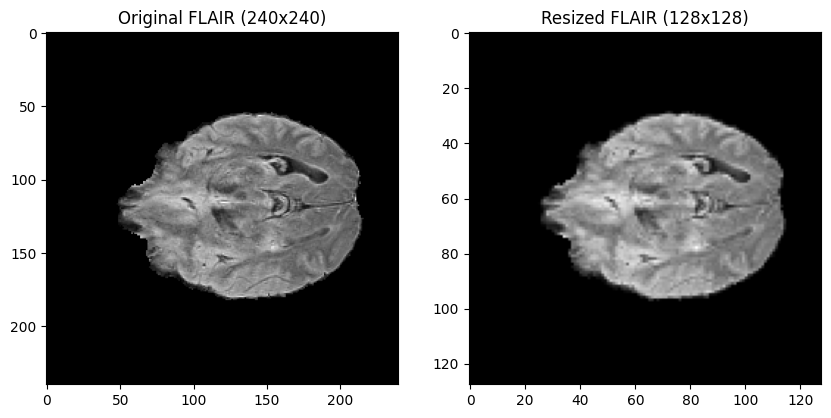

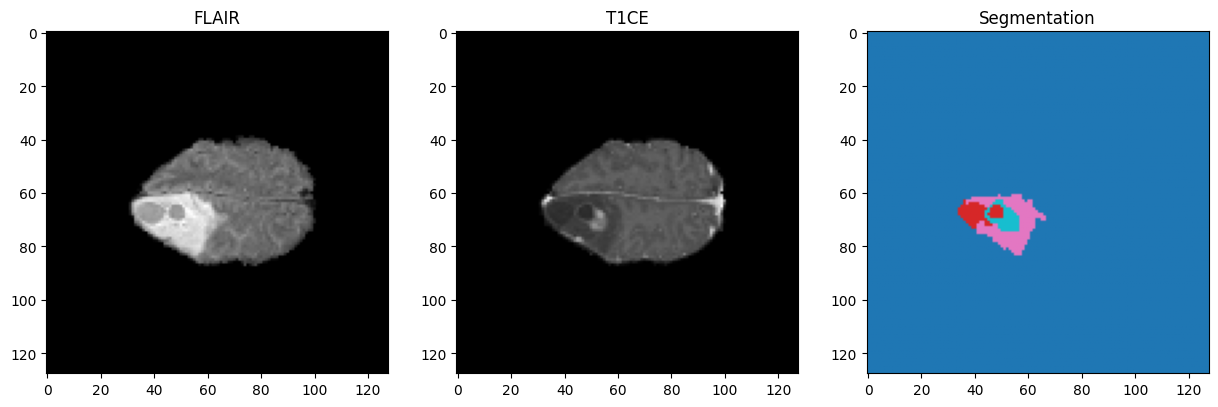

In [108]:
visualize_sample(train_gen, slice_index=60)